In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/



Saving kaggle.json to kaggle.json


In [2]:
!chmod 600 ~/.kaggle/kaggle.json
#unzip the folder
!mkdir train

In [5]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 7.80MB/s]


In [6]:
!unzip pima-indians-diabetes-database.zip -d train


Archive:  pima-indians-diabetes-database.zip
  inflating: train/diabetes.csv      


In [13]:
# example of a super learner model for binary classification
from numpy import hstack
from numpy import vstack
from numpy import asarray
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [9]:
# load the data
data = pd.read_csv('/content/train/diabetes.csv')
df = data.copy()
feature_columns = list(df.columns)
feature_columns.remove('Outcome')
from sklearn.impute import SimpleImputer
fill_values = SimpleImputer(missing_values=0, strategy="mean", copy=False)
df[feature_columns] = fill_values.fit_transform(df[feature_columns])
# split the data into train and test
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [55]:
# create a list of base-models
def get_models():
	models = list()
	models.append(LogisticRegression(solver='liblinear'))
	models.append(DecisionTreeClassifier())
	models.append(SVC(gamma='scale', probability=True))
	models.append(GaussianNB())
	models.append(KNeighborsClassifier())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier(n_estimators=10))
	models.append(RandomForestClassifier(n_estimators=10))
	models.append(ExtraTreesClassifier(n_estimators=10))
	return models
 
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict_proba(test_X)
			# store columns
			fold_yhats.append(yhat)
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)
 
# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
 
# fit a meta model
def fit_meta_model(X, y):
	model = LogisticRegression(solver='liblinear')
	model.fit(X, y)
	return model
 
# evaluate a list of models on a dataset
scores = {}
def evaluate_models_enhance(X_train, X_test, y_train, y_test, models):
  for model in models:
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    # print(f'Metrics for {model.__class__.__name__} :\n')
    # print("TRAINIG RESULTS: \n-------------------------------")
    # clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    # print(f"ACCURACY SCORE: {(accuracy_score(y_train, y_train_pred))*100}")
    # print('\n')
    # print("TESTING RESULTS: \n-------------------------------")
    # clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    # print(f"ACCURACY SCORE: {(accuracy_score(y_test, y_test_pred))*100}")
    # print("\n=================================")
    scores[model.__class__.__name__] = {
        'Train': (accuracy_score(y_train, y_train_pred))*100,
        'Test': (accuracy_score(y_test, y_test_pred))*100,
    }
    print(scores)
                      
# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict_proba(X)
		meta_X.append(yhat)
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)
 
# evaluate a list of models based on stacked prediction
# def evaluate_models_stack(X_train, X_test, y_train, y_test, models, meta_model):
#   for model in models:
#     yhat_train = super_learner_predictions(X_train, models, meta_model)
#     yhat_test = super_learner_predictions(X_test, models, meta_model)
#     print("RESULTS FOR SUPER LEARNER: \n-------------------------------")
#     clf_report = pd.DataFrame(classification_report(y_train, yhat_train, output_dict=True))
#     print(f"ACCURACY SCORE ON TRAIN: {(accuracy_score(y_train, yhat_train))*100}")
#     print('\n')
#     clf_report = pd.DataFrame(classification_report(y_test, yhat_test, output_dict=True))
#     print(f"ACCURACY SCORE ON TEST: {(accuracy_score(y_test, yhat_test))*100}")
#     print("\n=================================")

In [56]:
print('Train', X.shape, y.shape, 'Test', X_test.shape, y_test.shape)
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X_train, y_train, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models_enhance(X_train, X_test, y_train, y_test, models)
# evaluate stacked model
# evaluate_models_stack(X_train, X_test, y_train, y_test, models, meta_model)
yhat_train = super_learner_predictions(X_train, models, meta_model)
yhat_test = super_learner_predictions(X_test, models, meta_model)
print("RESULTS FOR SUPER LEARNER: \n-------------------------------")
clf_report = pd.DataFrame(classification_report(y_train, yhat_train, output_dict=True))
print(f"ACCURACY SCORE ON TRAIN: {(accuracy_score(y_train, yhat_train))*100}")
print('\n')
clf_report = pd.DataFrame(classification_report(y_test, yhat_test, output_dict=True))
print(f"ACCURACY SCORE ON TEST: {(accuracy_score(y_test, yhat_test))*100}")
print("\n=================================")
 
# print('Super Learner: %.3f' % (accuracy_score(y_test, yhat) * 100))

Train (768, 8) (768,) Test (231, 8) (231,)
Meta  (768, 18) (768,)
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 73.59307359307358}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 73.59307359307358}, 'SVC': {'Train': 78.02607076350093, 'Test': 74.45887445887446}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 73.59307359307358}, 'SVC': {'Train': 78.02607076350093, 'Test': 74.45887445887446}, 'GaussianNB': {'Train': 77.6536312849162, 'Test': 74.45887445887446}}
{'LogisticRegression': {'Train': 78.58472998137802, 'Test': 73.59307359307358}, 'DecisionTreeClassifier': {'Train': 100.0, 'Test': 73.59307359307358}, 'SVC': {'Train': 78.02607076350093, 'Test': 74.45887

In [61]:
scores['stacked'] = {
        'Train': (accuracy_score(y_train, yhat_train))*100,
        'Test': (accuracy_score(y_test, yhat_test))*100
    }
scores

{'AdaBoostClassifier': {'Test': 74.02597402597402, 'Train': 84.17132216014897},
 'BaggingClassifier': {'Test': 75.32467532467533, 'Train': 97.76536312849163},
 'DecisionTreeClassifier': {'Test': 73.59307359307358, 'Train': 100.0},
 'ExtraTreesClassifier': {'Test': 73.16017316017316, 'Train': 100.0},
 'GaussianNB': {'Test': 74.45887445887446, 'Train': 77.6536312849162},
 'KNeighborsClassifier': {'Test': 71.86147186147186,
  'Train': 80.63314711359403},
 'LogisticRegression': {'Test': 73.59307359307358, 'Train': 78.58472998137802},
 'RandomForestClassifier': {'Test': 76.19047619047619,
  'Train': 97.95158286778398},
 'SVC': {'Test': 74.45887445887446, 'Train': 78.02607076350093},
 'stacked': {'Test': 76.19047619047619, 'Train': 98.69646182495345}}

In [62]:
import matplotlib.pyplot as plt

scores_df = pd.DataFrame(scores)

In [63]:
scores_df

,LogisticRegression,DecisionTreeClassifier,SVC,GaussianNB,KNeighborsClassifier,AdaBoostClassifier,BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,stacked
Train,78.584730,100.000000,78.026071,77.653631,80.633147,84.171322,97.765363,97.951583,100.000000,98.696462
Test,73.593074,73.593074,74.458874,74.458874,71.861472,74.025974,75.324675,76.190476,73.160173,76.190476


In [72]:
long_df = scores_df.reset_index()

In [73]:
long_df

,index,LogisticRegression,DecisionTreeClassifier,SVC,GaussianNB,KNeighborsClassifier,AdaBoostClassifier,BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,stacked
0,Train,78.584730,100.000000,78.026071,77.653631,80.633147,84.171322,97.765363,97.951583,100.000000,98.696462
1,Test,73.593074,73.593074,74.458874,74.458874,71.861472,74.025974,75.324675,76.190476,73.160173,76.190476


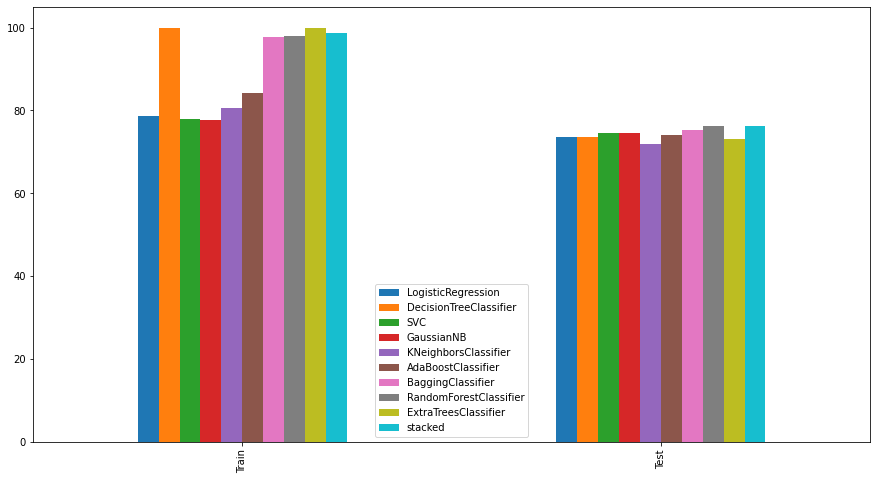

In [74]:
scores_df.plot(kind='bar', figsize=(15, 8))